# 状態空間モデルによる予測と補間

ここでは、ローカルレベルモデルによる将来の時系列データの予測と欠損値の補間について扱う。
まず、予測について実装する。

## 予測

In [25]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

import stan
import nest_asyncio
nest_asyncio.apply()

In [2]:
sales = pd.read_csv('../data/4-2-sales.csv')

In [38]:
dt = [datetime.strptime(i, "%Y-%m-%d") for i in sales["date"]]

In [3]:
y = sales['sales'].values

In [4]:
stan_data = {
    "T": len(y),
    "y": y,
    "pred_term": 20
}

In [10]:
with open("../stan/4-3-local-level-model-pred.stan", "r") as f:
    stan_code = f.read()

In [11]:
sm = stan.build(stan_code, data=stan_data, random_seed=123)

Building...

In file included from /usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/Core:215,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/Dense:1,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun/Eigen.hpp:22,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/rev.hpp:4,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math.hpp:19,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /root/.cache/httpstan/4.12.0/models/uit2biu3/model_uit2biu3.cpp:2:
/usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/src/Core/arch/NEON/PacketMath.h: In function ‘Packet Eigen::internal::pload(const typename unpacket_traits<T>::type*) [with Packet = eigen_packet_wrapper<int, 2>; typename unpacket_traits<T>::type = signed char]’:
/usr/local/lib/python3.11/


Building: 19.0s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [12]:
fit = sm.sample(num_chains=3, num_samples=9000, num_warmup=1000, num_thin=3)

Sampling:   0%
Sampling:   1% (200/30000)
Sampling:   2% (600/30000)
Sampling:   3% (900/30000)
Sampling:  36% (10700/30000)
Sampling:  68% (20300/30000)
Sampling: 100% (30000/30000)
Sampling: 100% (30000/30000), done.
Messages received during sampling:
  Gradient evaluation took 5.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_ulqxaict/model_uit2biu3.stan', line 15, column 8 to column 37)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if thi

In [15]:
summary = az.summary(fit, var_names=["mu", "mu_pred", "s_w", "s_v"])
display(summary)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],21.504,1.748,18.232,24.693,0.019,0.013,8516.0,8503.0,1.0
mu[1],20.991,1.531,18.131,23.830,0.016,0.011,9071.0,8783.0,1.0
mu[2],20.935,1.428,18.247,23.627,0.015,0.011,8496.0,8050.0,1.0
mu[3],21.048,1.383,18.431,23.671,0.015,0.011,8623.0,8797.0,1.0
mu[4],20.444,1.369,17.927,23.092,0.015,0.010,8837.0,8225.0,1.0
...,...,...,...,...,...,...,...,...,...
mu_pred[117],9.394,5.967,-2.161,20.500,0.063,0.045,9023.0,7982.0,1.0
mu_pred[118],9.384,6.099,-2.426,20.596,0.064,0.046,9034.0,8149.0,1.0
mu_pred[119],9.371,6.242,-2.608,20.996,0.066,0.047,8985.0,8180.0,1.0
s_w,1.310,0.293,0.807,1.863,0.006,0.005,2008.0,3849.0,1.0


In [39]:
dt_pred = dt.copy()
for i in range(1, 21):
    dt_pred.append(dt[-1] + timedelta(days=i))

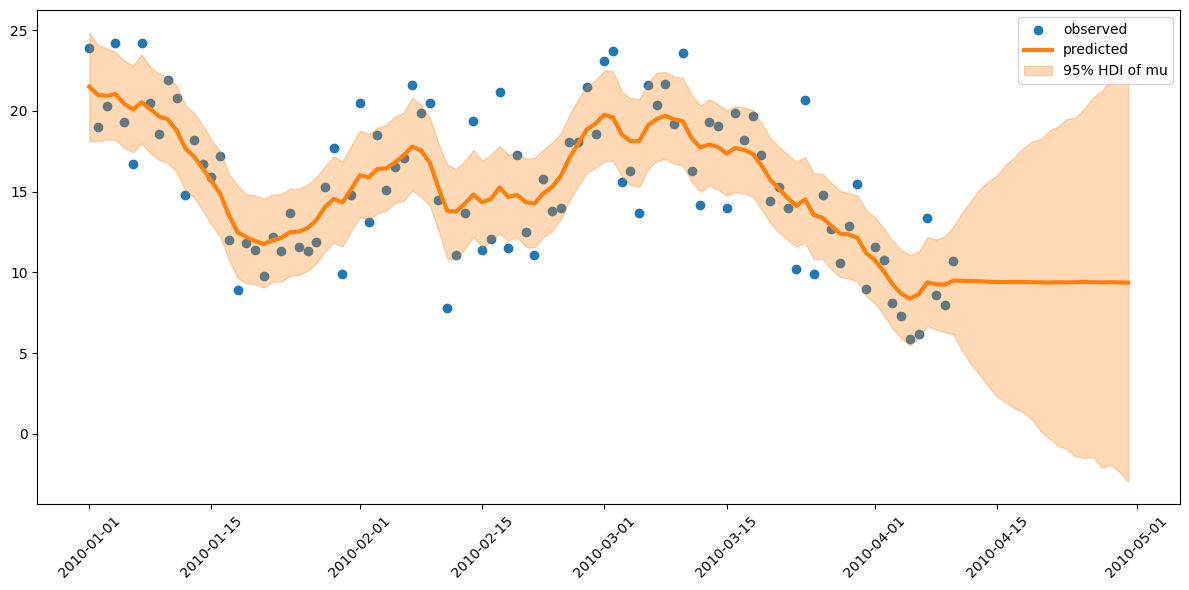

In [40]:
cmap = plt.get_cmap("tab10")

hdis = az.hdi(fit, hdi_prob=0.95)["mu_pred"].values
mu_mean = az.summary(fit, var_names=["mu_pred"])["mean"].values

fig, axes = plt.subplots(1, 1, figsize=(12, 6))
axes.scatter(dt, sales["sales"], color=cmap(0), label="observed")
axes.plot(dt_pred, mu_mean, color=cmap(1), label="predicted", lw=3)
axes.fill_between(dt_pred, y1=hdis[:,0], y2=hdis[:,1], color=cmap(1), alpha=0.30, label="95% HDI of mu")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

20ステップ分予測したところ、予測値は最後の観測値が得られた4/10からほとんど変化していない。

これは、ローカルレベルモデルが前のステップの状態を期待値とするためで、ローカルレベルモデルのような単純なモデルでは将来予測は難しい。

ベイズ信用区間を見ると、時間が経つにつれ信用区間が大きくなっていることがわかる。これは時間が遠いほど予測が難しいことを表している。

## 欠損値の補間

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

import stan
import nest_asyncio
nest_asyncio.apply()

In [2]:
sales = pd.read_csv('../data/4-3-sales-NA.csv')

In [3]:
sales.isnull().sum()

date      0
sales    26
dtype: int64

このデータは欠損値を26日分含む。

In [4]:
sales[~sales["sales"].isnull()]

,date,sales
0,2010-01-01,23.9
1,2010-01-02,19.0
3,2010-01-04,24.2
4,2010-01-05,19.3
5,2010-01-06,16.7
...,...,...
95,2010-04-06,6.2
96,2010-04-07,13.4
97,2010-04-08,8.6
98,2010-04-09,8.0


In [14]:
T = len(sales)
y = sales[~sales["sales"].isnull()]["sales"].values
len_obs = T - sum(sales["sales"].isnull())
obs_no = sales[~sales["sales"].isnull()].index.values + 1

In [15]:
stan_data = {
    "y": y,
    "T": T,
    "len_obs": len_obs,
    "obs_no": obs_no
}

In [16]:
with open("../stan/4-3-2-local-level-model-interpolation.stan", "r") as f:
    stan_code = f.read()

In [17]:
sm = stan.build(stan_code, data=stan_data, random_seed=123)

Building...

In file included from /usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/Core:215,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/Dense:1,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun/Eigen.hpp:22,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/rev.hpp:4,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math.hpp:19,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /root/.cache/httpstan/4.12.0/models/3u7fucek/model_3u7fucek.cpp:2:
/usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/src/Core/arch/NEON/PacketMath.h: In function ‘Packet Eigen::internal::pload(const typename unpacket_traits<T>::type*) [with Packet = eigen_packet_wrapper<int, 2>; typename unpacket_traits<T>::type = signed char]’:
/usr/local/lib/python3.11/


Building: 21.4s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [18]:
fit = sm.sample(num_chains=3, num_samples=9000, num_warmup=1000, num_thin=3)

Sampling:   0%
Sampling:   0% (100/30000)
Sampling:   1% (300/30000)
Sampling:   2% (500/30000)
Sampling:  35% (10400/30000)
Sampling:  67% (20200/30000)
Sampling: 100% (30000/30000)
Sampling: 100% (30000/30000), done.
Messages received during sampling:
  Gradient evaluation took 6.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_zv8h2wzs/model_3u7fucek.stan', line 16, column 8 to column 37)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if thi

In [20]:
sales_not_null = pd.read_csv('../data/4-2-sales.csv')

In [21]:
dt = [datetime.strptime(i, "%Y-%m-%d") for i in sales_not_null["date"]]

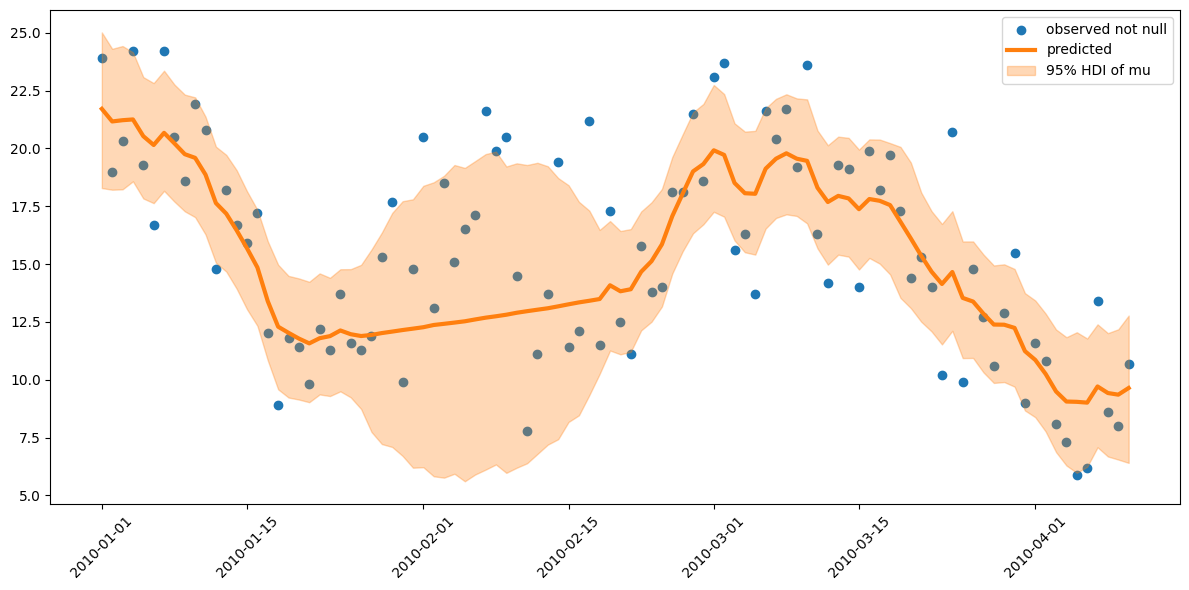

In [23]:
cmap = plt.get_cmap("tab10")

hdis = az.hdi(fit, hdi_prob=0.95)["mu"].values
mu_mean = az.summary(fit, var_names=["mu"])["mean"].values

fig, axes = plt.subplots(1, 1, figsize=(12, 6))
axes.scatter(dt, sales_not_null["sales"], color=cmap(0), label="observed not null")
axes.plot(dt, mu_mean, color=cmap(1), label="predicted", lw=3)
axes.fill_between(dt, y1=hdis[:,0], y2=hdis[:,1], color=cmap(1), alpha=0.30, label="95% HDI of mu")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()